## Python Frontend
This notebook demonstrates the Python frontend to MPB.

In [1]:
%load_ext autoreload
%autoreload 2
from mpb import MPB, MultipleMPB
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
# make sure to not use Level-3 fonts
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
from copy import deepcopy
import math
mpb = MPB()
mpb["ompl.seed"] = 5  # set the seed of the OMPL planners
mpb.set_planners(['rrt_star'])
mpb.set_steer_functions(['car'])
mpb["steer.car_turning_radius"] = 0.5
mpb["steer.sampling_resolution"] = 0.01
mpb["max_planning_time"] = 5

folder_prefix = "/home/ksatyaki/workspace/bench_ws/src/bench-mr/"
mpb["env.collision.robot_shape_source"] = folder_prefix + "maps/simple_robot.yaml"
mpb.set_image_yaml_env(folder_prefix + "maps/office_cubicles.yaml")
cliff_map_file = folder_prefix + "maps/office_cubicles_cliffmap.xml"
intensity_map_file = folder_prefix + "maps/office_cubicles_intensitymap.xml"
gmmt_map_file = folder_prefix + "maps/office_cubicles_gmmtmap.xml"

cost_fns = ["dtc", "cliff", "gmmt", "intensity"]
cost_fn_map = { "dtc" : cliff_map_file, "cliff" : cliff_map_file, "intensity": intensity_map_file, "gmmt": gmmt_map_file }
mpb.set_start(-5.0, -5.0, math.pi / 4.0)
mpb.set_goal(19.0, 19.0, math.pi / 4.0)

Lets run some tests on the cubicles map. . .

In [2]:
mpbs = dict()
for cost_fn in cost_fns:
  intensity_mpb = deepcopy(mpb)
  intensity_mpb["ompl.sampler"] = "intensity"
  intensity_mpb.set_id('{}-{}'.format(cost_fn, 'intensity'))
  intensity_mpb["ompl.intensity_map_file_name"] = intensity_map_file
  intensity_mpb["ompl.optimization_objective"] = cost_fn
  intensity_mpb["mod.mod_file_name"] = cost_fn_map[cost_fn]
  mpbs['{}-{}'.format(cost_fn, 'intensity')] = intensity_mpb

  uniform_mpb = deepcopy(mpb)
  uniform_mpb["ompl.sampler"] = "iid"
  uniform_mpb.set_id('{}-{}'.format(cost_fn, 'uniform'))
  intensity_mpb["ompl.optimization_objective"] = cost_fn
  intensity_mpb["mod.mod_file_name"] = cost_fn_map[cost_fn]
  mpbs['{}-{}'.format(cost_fn, 'uniform')] = uniform_mpb

Run the motion planning benchmark:

In [4]:
for key in mpbs:
  mpbs[key].run(id=key, runs=10, subfolder=folder_prefix + "/python/mod-tests" )

Running MPB with ID dtc-intensity (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests/dtc-intensity.log)...


dtc-intensity:   0%|          | 0/10 [00:00<?, ?it/s]

Running MPB with ID dtc-uniform (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests/dtc-uniform.log)...


dtc-uniform:   0%|          | 0/10 [00:00<?, ?it/s]

Running MPB with ID cliff-intensity (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests/cliff-intensity.log)...


cliff-intensity:   0%|          | 0/10 [00:00<?, ?it/s]

Running MPB with ID cliff-uniform (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests/cliff-uniform.log)...


cliff-uniform:   0%|          | 0/10 [00:00<?, ?it/s]

Running MPB with ID gmmt-intensity (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests/gmmt-intensity.log)...


gmmt-intensity:   0%|          | 0/10 [00:00<?, ?it/s]

Running MPB with ID gmmt-uniform (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests/gmmt-uniform.log)...


gmmt-uniform:   0%|          | 0/10 [00:00<?, ?it/s]

Running MPB with ID intensity-intensity (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests/intensity-intensity.log)...


intensity-intensity:   0%|          | 0/10 [00:00<?, ?it/s]

Running MPB with ID intensity-uniform (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests/intensity-uniform.log)...


intensity-uniform:   0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
print(mpbs['dtc-intensity'].results_filename)
MPB.merge(mpbs.values(), target_filename="mod-tests/mod-tests-combined.json", plan_names=list(mpbs.keys()))

/home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests/dtc-intensity_results.json
Successfully merged [/home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests/dtc-intensity_results.json, /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests/dtc-uniform_results.json, /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests/cliff-intensity_results.json, /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests/cliff-uniform_results.json, /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests/gmmt-intensity_results.json, /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests/gmmt-uniform_results.json, /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests/intensity-intensity_results.json, /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests/intensity-uniform_results.json] into mod-tests/mod-tests-combined.json.


Visualize the planner trajectories:

Visualizing mod-tests/mod-tests-combined.json
Saved MoD-planning-paths.pdf.


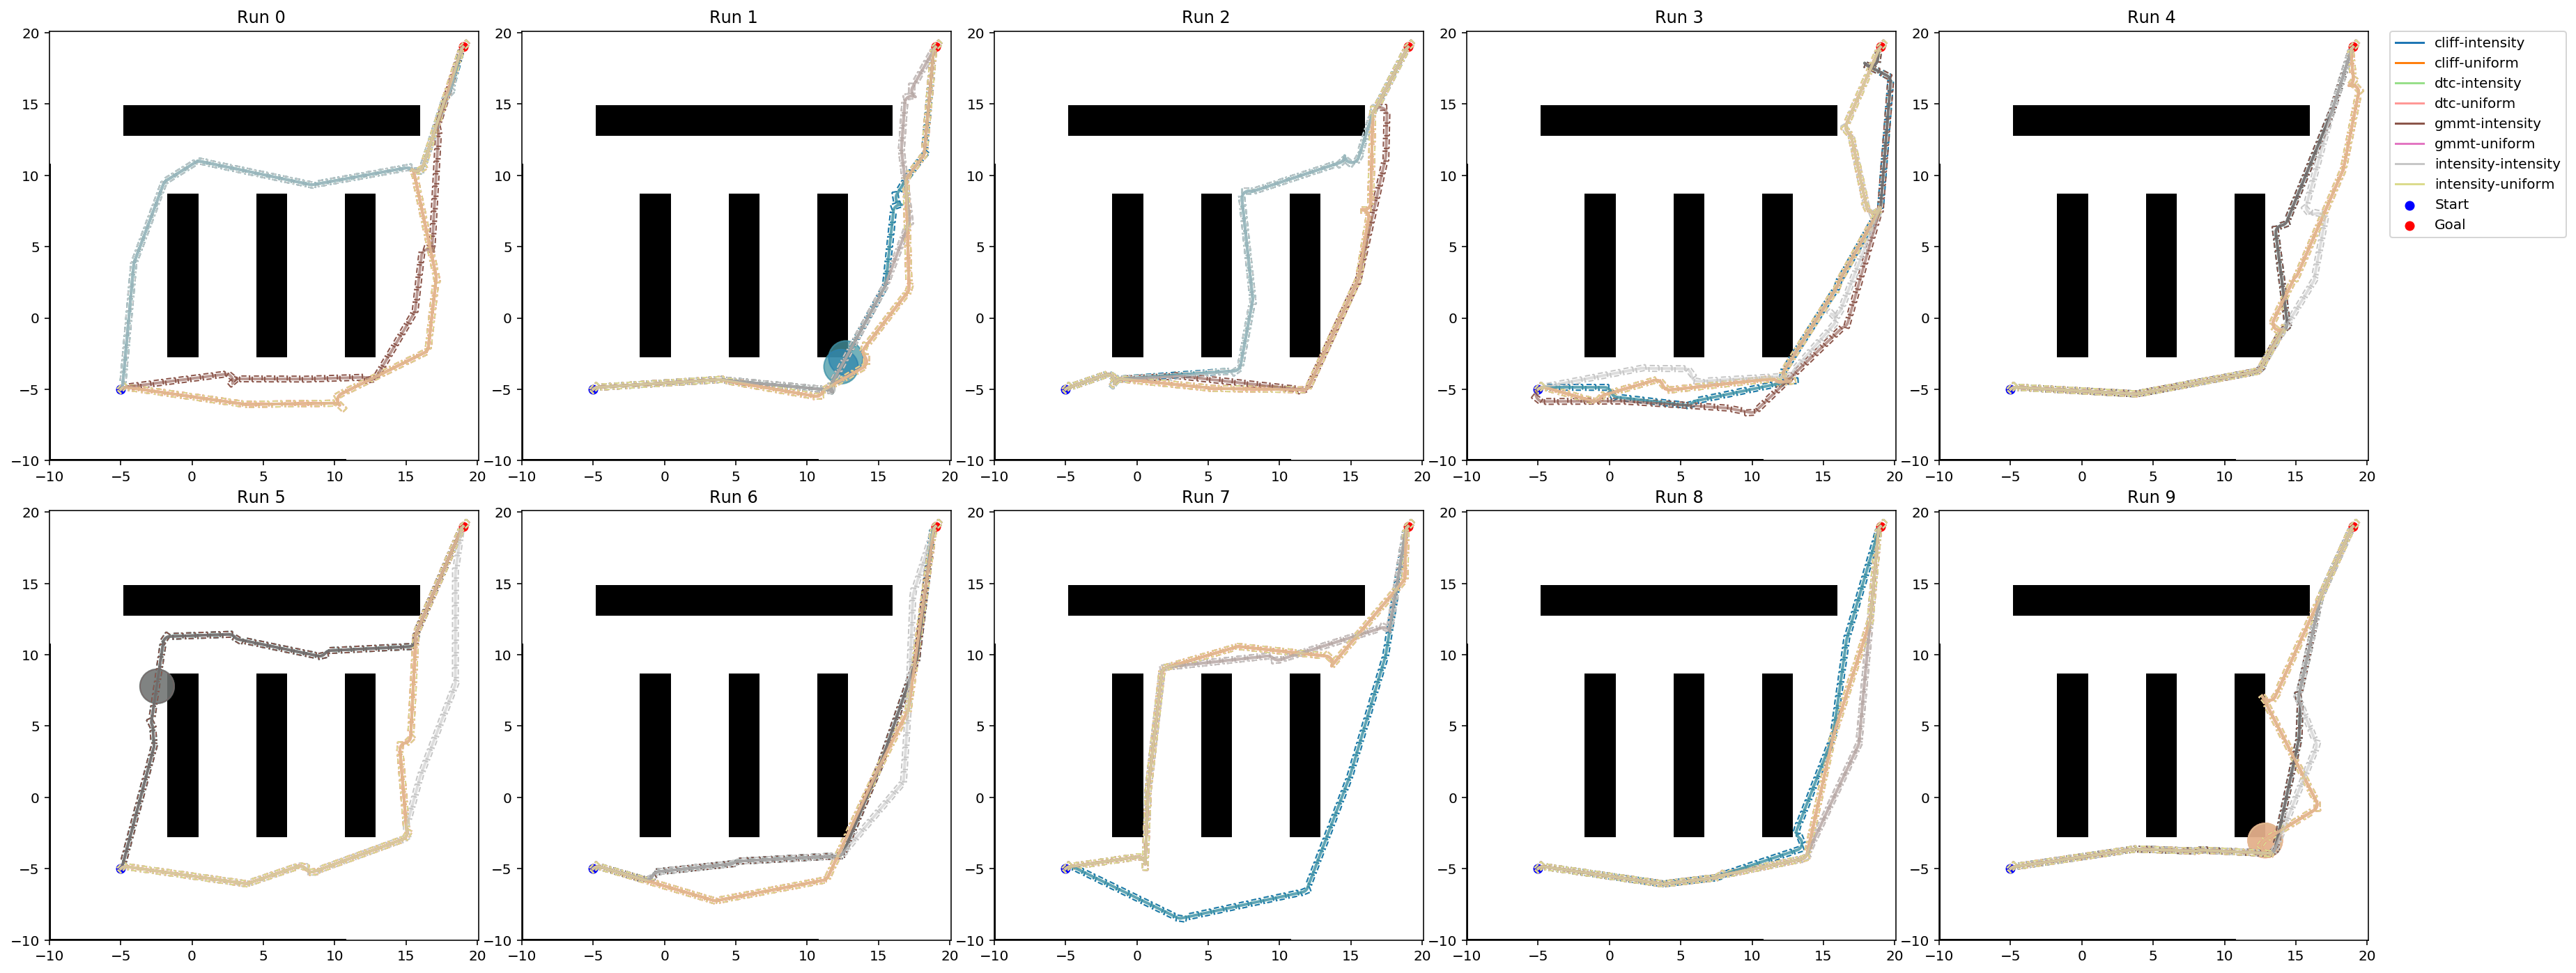

In [6]:
from trajectory import visualize
visualize('mod-tests/mod-tests-combined.json', save_file="MoD-planning-paths.pdf")

Plot planner statistics:

Visualizing dtc-intensity-vs-uniform/dtc-intensity-vs-uniform.json...


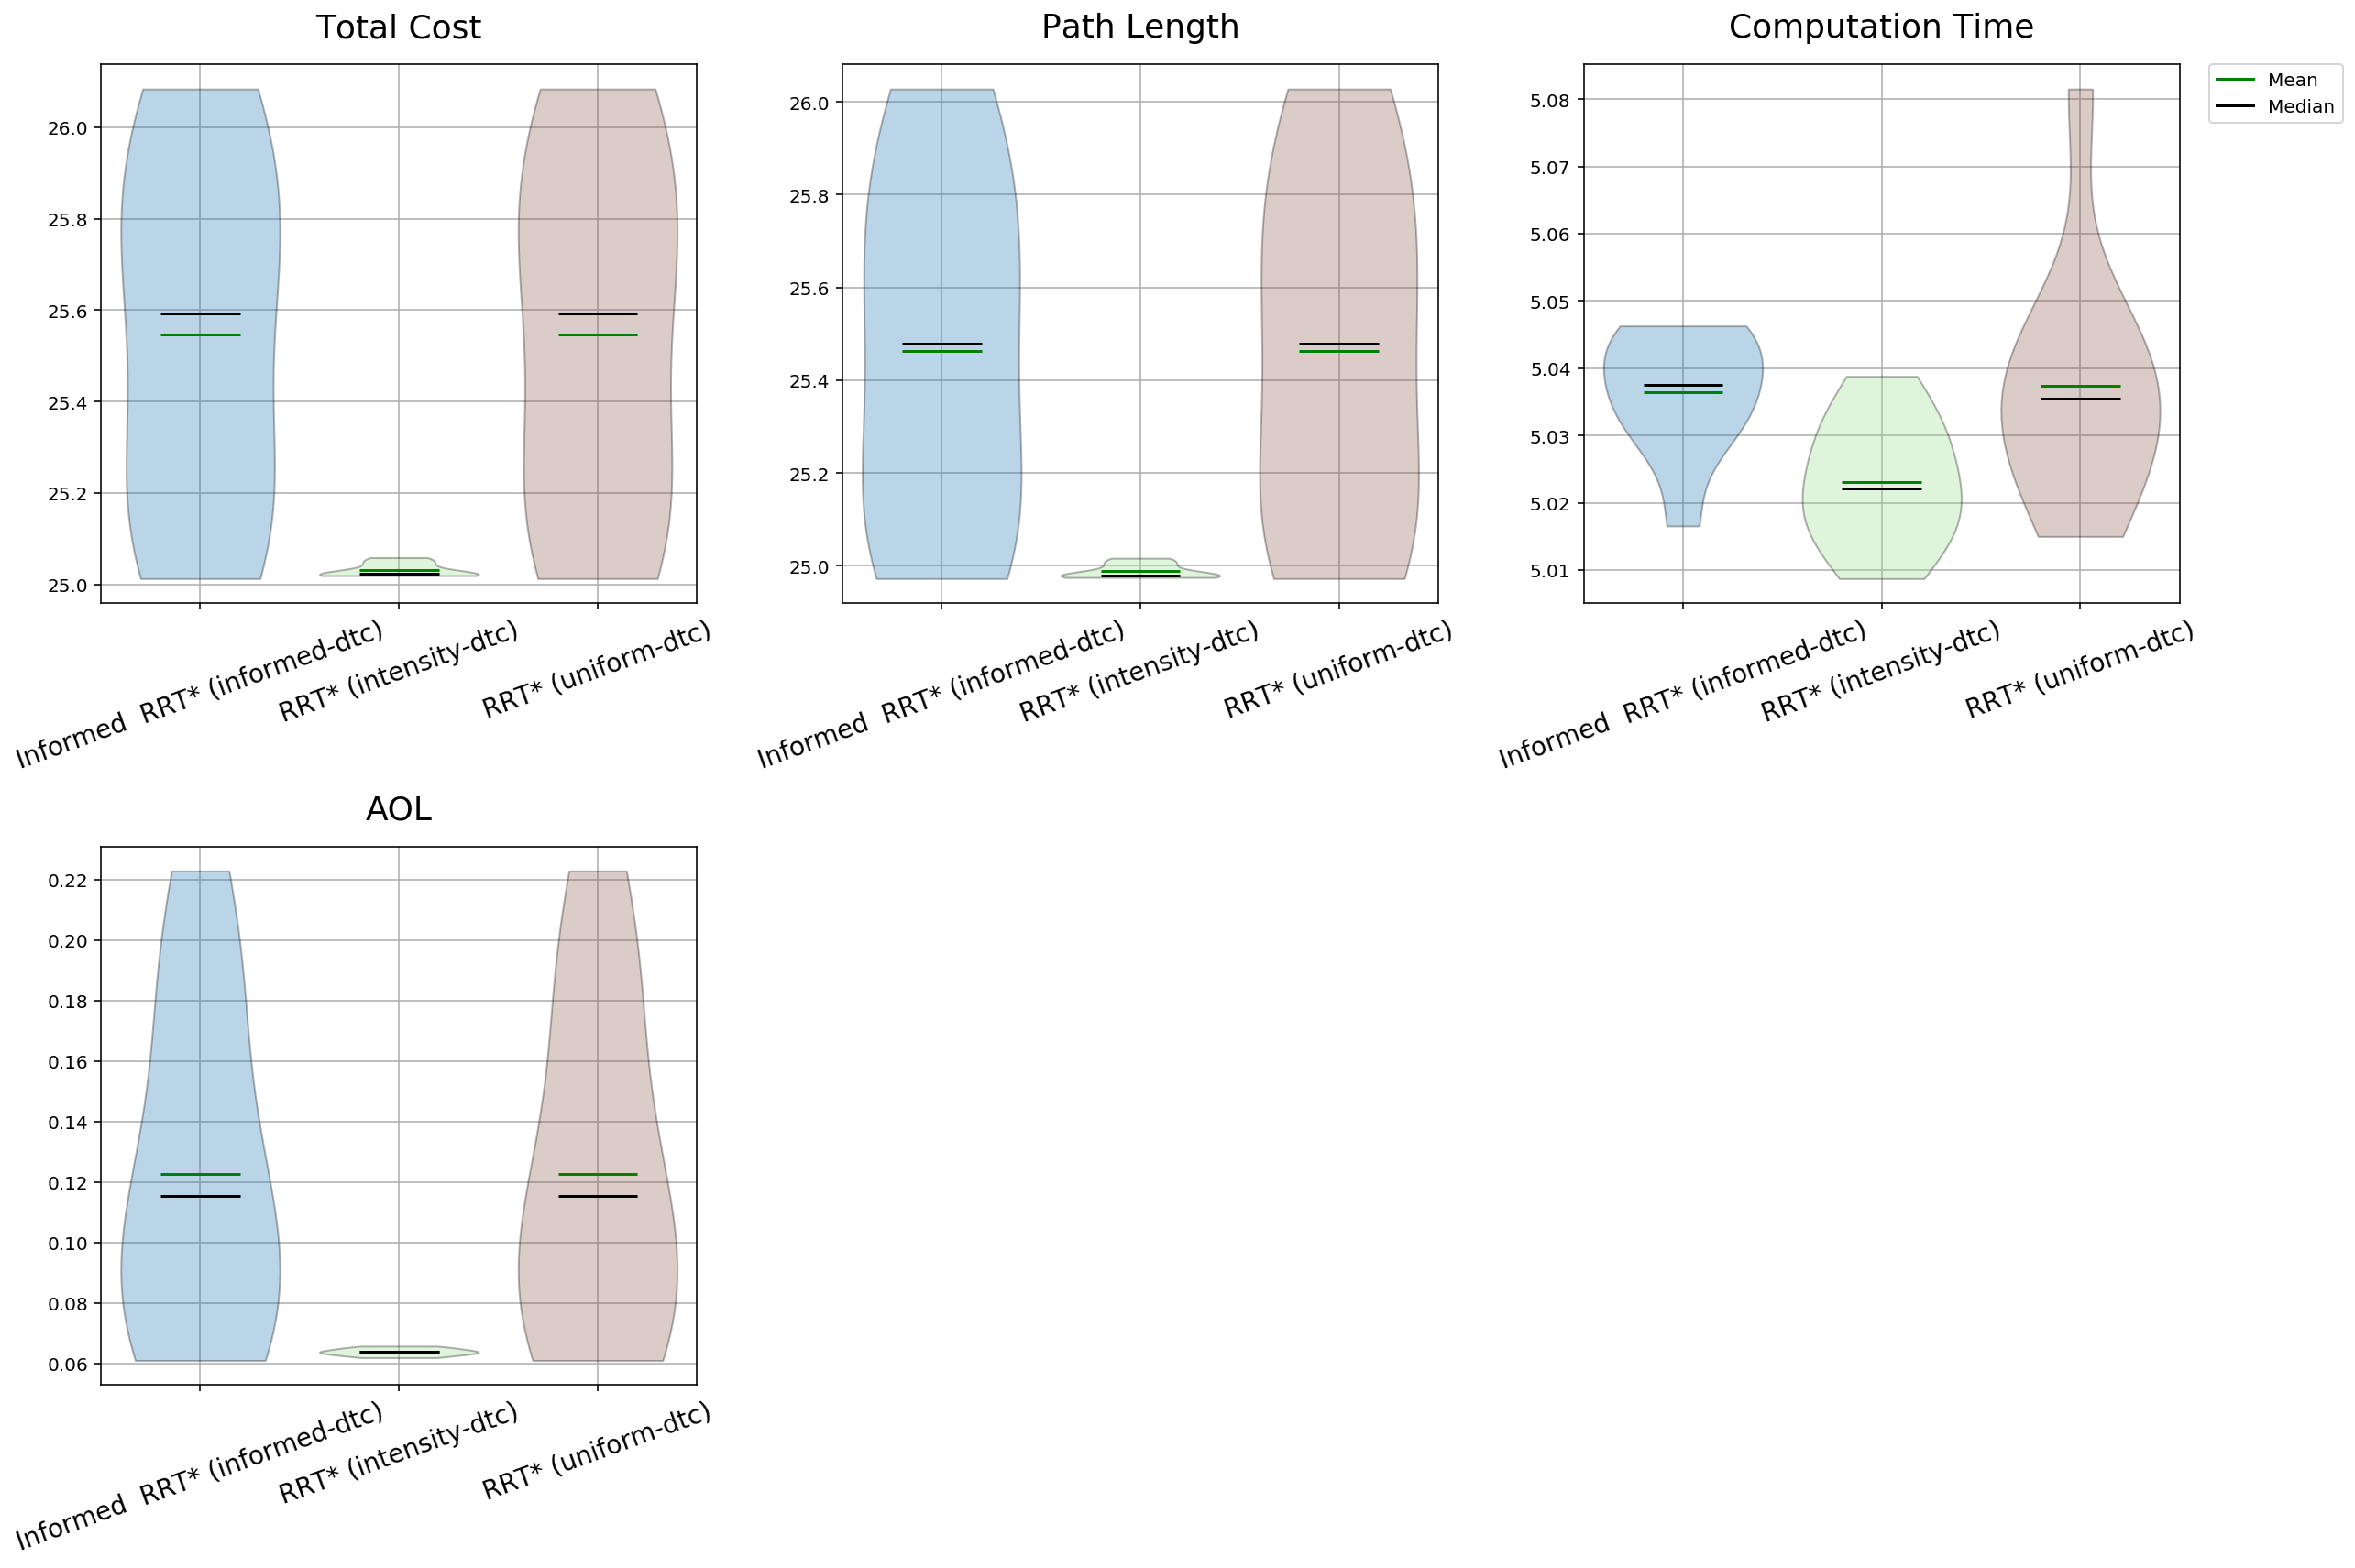

In [9]:
from plot_stats import plot_planner_stats
cost_fn = 'dtc'
plot_planner_stats('{}-intensity-vs-uniform/{}-intensity-vs-uniform.json'.format(cost_fn, cost_fn), metrics='total_cost,path_length,planning_time,aol', num_colors=4, ticks_rotation=20)